In [1]:
import pandas as pd

# Load the expression data (assumes TSV format)
expression_df = pd.read_csv("expression", sep="\t", index_col=0)

# Preview structure
print("Expression shape:", expression_df.shape)
expression_df.head()

Expression shape: (20530, 550)


,TCGA-XJ-A83F-01,TCGA-G9-6348-01,TCGA-CH-5766-01,TCGA-EJ-A65G-01,TCGA-G9-6354-01,TCGA-EJ-5527-01,TCGA-HC-8213-01,TCGA-Y6-A9XI-01,TCGA-EJ-7125-11,TCGA-CH-5744-01,...,TCGA-HC-A6AP-01,TCGA-EJ-7317-01,TCGA-YL-A8S9-01,TCGA-KK-A8IA-01,TCGA-G9-6356-01,TCGA-YL-A8SO-01,TCGA-J4-A67Q-01,TCGA-KK-A6E4-01,TCGA-KK-A7B0-01,TCGA-EJ-5511-01
sample,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,9.3554,8.8729,8.5581,9.2085,9.0514,8.7699,8.5544,9.0878,8.4893,9.4441,...,9.9893,9.8316,9.5040,8.9076,9.6466,9.2028,9.6899,8.5757,9.7088,9.2665
HIF3A,5.1517,5.9049,4.9716,6.7795,5.3511,5.5978,3.7947,4.7539,6.9225,4.8565,...,7.4100,6.3570,3.2686,4.8980,6.3657,5.8463,8.6302,5.4474,6.0986,5.8144
RNF17,0.0000,0.4008,0.7574,0.0000,0.0000,2.5554,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.4256,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
RNF10,12.4656,12.3538,12.2950,11.9701,12.5973,11.7983,12.4055,12.2347,11.5627,12.3659,...,12.0948,12.2781,11.7392,12.1408,12.1805,12.5294,12.0489,11.9228,12.5002,11.9083
RNF11,11.1274,11.5348,11.9867,11.3146,11.3622,11.7041,11.4244,11.6855,12.0737,11.3862,...,10.8254,11.2658,11.1787,11.2560,11.0933,11.2810,10.9468,10.2378,9.8724,10.8594


STEP 2: Transpose and Standardize Expression Data

In [2]:
from sklearn.preprocessing import StandardScaler

# Transpose: samples as rows, genes as columns
expression_df_T = expression_df.T

# Standardize (Z-score normalization per gene)
scaler = StandardScaler()
expression_scaled = pd.DataFrame(
    scaler.fit_transform(expression_df_T),
    index=expression_df_T.index,
    columns=expression_df_T.columns
)

# Output shape
expression_scaled.shape, expression_scaled.head()

((550, 20530),
 sample           ARHGEF10L     HIF3A     RNF17     RNF10     RNF11     RNF13  \
 TCGA-XJ-A83F-01  -0.198374 -0.454546 -0.366337  1.070973 -0.200493 -0.261319   
 TCGA-G9-6348-01  -1.170079  0.004504  0.194212  0.672901  0.848621 -0.243448   
 TCGA-CH-5766-01  -1.804054 -0.564311  0.692944  0.463539  2.012329  1.302778   
 TCGA-EJ-A65G-01  -0.494215  0.537543 -0.366337 -0.693292  0.281574  1.533880   
 TCGA-G9-6354-01  -0.810599 -0.333018 -0.366337  1.539901  0.404151 -0.113453   
 
 sample            GTF2IP1      REM1     MTVR2   RTN4RL2  ...     TULP2  \
 TCGA-XJ-A83F-01  0.671369 -0.127245 -0.415703  0.331401  ... -0.107846   
 TCGA-G9-6348-01 -0.919579  0.410177  1.089545  0.979373  ... -0.509765   
 TCGA-CH-5766-01 -0.488732 -0.320288 -0.415703  1.205095  ... -0.470073   
 TCGA-EJ-A65G-01  0.070866 -1.330817 -0.415703  0.808655  ... -1.098973   
 TCGA-G9-6354-01 -0.115891 -0.709376 -0.415703  0.043328  ... -1.098973   
 
 sample              NPY5R     GNGT2     GNGT

STEP 3: Align with Response Labels

In [3]:
# Load clinical data (if not already loaded)
clinical_df = pd.read_csv("phenotype", sep="\t", index_col=0)

# Extract binary response label
clinical_df['primary_therapy_outcome_success'] = clinical_df['primary_therapy_outcome_success'].fillna("Missing")
clinical_df['response'] = clinical_df['primary_therapy_outcome_success'].apply(lambda x: 1 if 'Complete' in str(x) else 0)

# Truncate sample IDs to 15 characters if needed
expression_scaled.index = expression_scaled.index.str[:15]
common_ids = expression_scaled.index.intersection(clinical_df.index)

# Align
X_expr = expression_scaled.loc[common_ids]
y_expr = clinical_df.loc[common_ids, 'response']

# Confirm shapes
X_expr.shape, y_expr.shape

((550, 20530), (550,))

STEP 4: Train-Test Split + Random Forest on Expression Data

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Train-test split
X_train_expr, X_test_expr, y_train_expr, y_test_expr = train_test_split(
    X_expr, y_expr, test_size=0.2, stratify=y_expr, random_state=42
)

# Train Random Forest
rf_expr = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_expr.fit(X_train_expr, y_train_expr)

# Predict + evaluate
y_probs_expr = rf_expr.predict_proba(X_test_expr)[:, 1]
y_preds_expr = rf_expr.predict(X_test_expr)

auc_expr = roc_auc_score(y_test_expr, y_probs_expr)
print(f"AUC: {auc_expr:.3f}")
print("\nClassification Report:\n", classification_report(y_test_expr, y_preds_expr))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_expr, y_preds_expr))


AUC: 0.725

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.18      0.27        33
           1       0.73      0.94      0.82        77

    accuracy                           0.71       110
   macro avg       0.64      0.56      0.55       110
weighted avg       0.67      0.71      0.65       110


Confusion Matrix:
 [[ 6 27]
 [ 5 72]]


Again, model is strong at identifying responders, but still weak at catching non-responders, low recall = many false positives, caught 72/77 responders, but missed 27/33 non responders

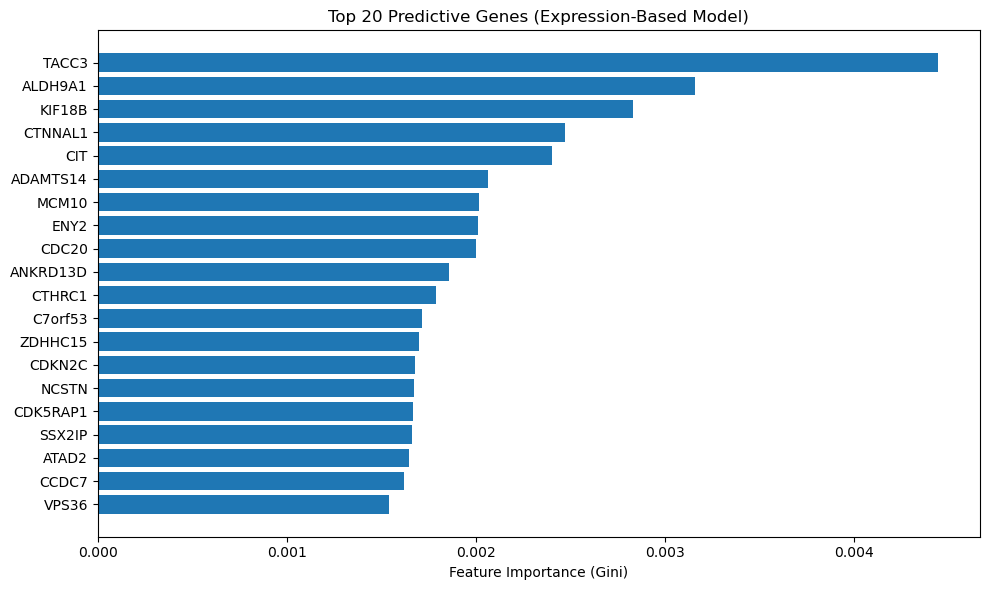

,Gene,Importance
6366,TACC3,0.004447
19483,ALDH9A1,0.003163
11895,KIF18B,0.002831
6512,CTNNAL1,0.002475
5126,CIT,0.002407
16189,ADAMTS14,0.002065
268,MCM10,0.002019
6984,ENY2,0.002013
12684,CDC20,0.002004
5680,ANKRD13D,0.001858


In [5]:
import matplotlib.pyplot as plt

# Extract feature importances from trained RF
importances_expr = rf_expr.feature_importances_
genes_expr = X_train_expr.columns

# Create and sort importance DataFrame
importance_df_expr = pd.DataFrame({
    'Gene': genes_expr,
    'Importance': importances_expr
}).sort_values(by='Importance', ascending=False)

# Plot top 20 genes
top_genes_expr = importance_df_expr.head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_genes_expr['Gene'][::-1], top_genes_expr['Importance'][::-1])
plt.xlabel("Feature Importance (Gini)")
plt.title("Top 20 Predictive Genes (Expression-Based Model)")
plt.tight_layout()
plt.show()

# Print table
top_genes_expr


no classic immune genes yet, so model may be learning indirect biology(tumor aggressiveness, cell cycle or confounded by expression noise from highly variable genes, importance values are relatively low and close together suggesting there is no single dominant feature, good for dimensionality reduction (sparsity(L1 model)))

STEP 5: Train L1 Logistic Regression (Lasso for Classification)
L1 forces many weights to exactly 0, AUTOMATIC feature selection
outputs directional coefficients

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Train-test split (reuse existing)
# X_train_expr, X_test_expr, y_train_expr, y_test_expr already exist

# Create L1 model pipeline
lasso_model = LogisticRegression(
    penalty='l1',
    solver='liblinear',  # supports L1
    class_weight='balanced',
    random_state=42,
    max_iter=1000
)

# Train
lasso_model.fit(X_train_expr, y_train_expr)

# Predict
y_probs_l1 = lasso_model.predict_proba(X_test_expr)[:, 1]
y_preds_l1 = lasso_model.predict(X_test_expr)

# Evaluate
auc_l1 = roc_auc_score(y_test_expr, y_probs_l1)
print(f"AUC: {auc_l1:.3f}")
print("\nClassification Report:\n", classification_report(y_test_expr, y_preds_l1))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_expr, y_preds_l1))


AUC: 0.573

Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.42      0.38        33
           1       0.72      0.65      0.68        77

    accuracy                           0.58       110
   macro avg       0.53      0.54      0.53       110
weighted avg       0.61      0.58      0.59       110


Confusion Matrix:
 [[14 19]
 [27 50]]


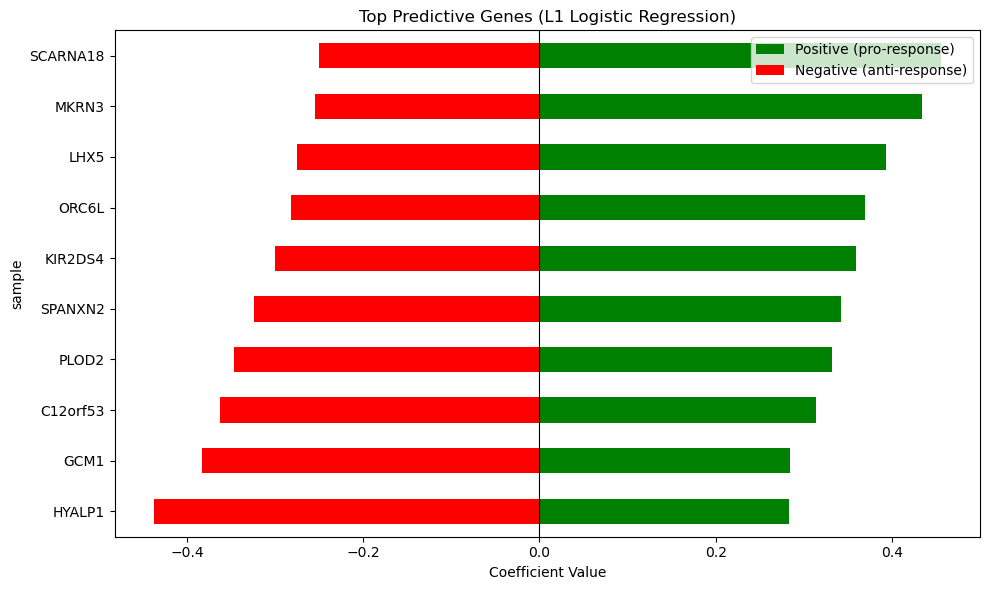

sample
NCRNA00110      0.455145
TBC1D3G         0.433688
FRG2C           0.393567
LOC151658       0.369645
ARL17A          0.359269
KRT20           0.341785
SNORA42         0.332379
MGC42105        0.313142
ATP5L2          0.284374
VN1R2           0.282983
SPATA12         0.269317
ZNF645          0.266086
AICDA           0.264664
NT5C1A          0.247579
LOC100128811    0.245867
ZNF490          0.238253
RDH8            0.224889
NFATC3          0.222188
ASH2L           0.214979
KHDC1           0.213963
dtype: float64

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Get non-zero coefficients
coefs = pd.Series(lasso_model.coef_[0], index=X_train_expr.columns)
nonzero_coefs = coefs[coefs != 0].sort_values()

# Plot
plt.figure(figsize=(10, 6))
nonzero_coefs.tail(10).plot(kind='barh', color='green', label='Positive (pro-response)')
nonzero_coefs.head(10).plot(kind='barh', color='red', label='Negative (anti-response)')
plt.xlabel("Coefficient Value")
plt.title("Top Predictive Genes (L1 Logistic Regression)")
plt.axvline(0, color='black', linewidth=0.8)
plt.legend()
plt.tight_layout()
plt.show()

# Show table
nonzero_coefs.sort_values(ascending=False).head(20)

We trained a sparse L1-regularized logistic regression model that identified 20 genes associated with response, though with reduced performance (AUC = 0.573) compared to the full Random Forest model (AUC = 0.725).

expression values are normalized RNAseq gene expression